#iPython notebook for simulating visibility dataset

This notebook uses code snippets from the crocodile python examples (https://github.com/SKA-ScienceDataProcessor/crocodile) to calculate the visibility data for a snapshot (i.e. single time sample) observation of a target field containing one point source. 

To run the script you will need:
 - ipython
 - numpy
 - pylab
 - VLA_A_hor_xyz.txt
 
The first three of these can be easily obtained using pip. 

To get pip: 

> apt-get install python-pip

To install each library:

>pip install numpy

etc.

The fourth is a text file supplied with this notebook. This script assumes it is in the working directory. 

In [1]:
%matplotlib inline

In [2]:
import numpy 
import matplotlib.pyplot as pl

The first thing we need to do is take the layout of our interferometer and convert it from Earth co-ordinates to UVW-coordinates, which are defined in the direction of our observation target. First, get the antenna positions:

In [3]:
ants_xyz=numpy.genfromtxt("./VLA_A_hor_xyz.txt", delimiter=",")
print "Number of antennas in array:",ants_xyz.shape[0]

Number of antennas in array: 27


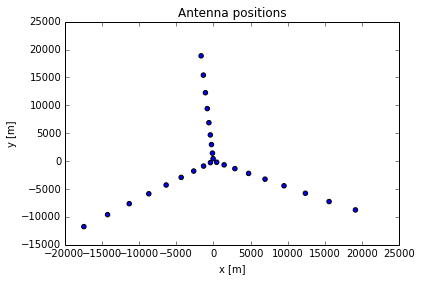

In [4]:
pl.scatter(ants_xyz[:,0],ants_xyz[:,1])
pl.title("Antenna positions")
pl.xlabel(r"x [m]")
pl.ylabel(r"y [m]");

Then get the position of the target. This is given in Hour Angle and Declination:

In [5]:
ha = 0.0; dec = numpy.pi/4.  # Units are Radians

With these inputs we can then calculate the UVW co-ordinates of the antennas:

In [13]:
x,y,z=numpy.hsplit(ants_xyz,3)

t=x*numpy.cos(ha) - y*numpy.sin(ha)
u=x*numpy.sin(ha) + y*numpy.cos(ha)
v=-1.*t*numpy.sin(dec)+ z*numpy.cos(dec)
w=t*numpy.cos(dec)+ z*numpy.sin(dec)

ants_uvw = numpy.hstack([u,v,w])
print ants_uvw

[[  -270.6395        284.694413     -282.807145  ]
 [  -889.0279        933.39947736   -930.52353266]
 [ -1782.7459       1874.41781816  -1863.34056617]
 [ -2920.6298       3064.71279538  -3058.74905678]
 [ -4283.1247       4485.83882151  -4494.43427012]
 [ -5856.4585       6134.22281529  -6144.66833808]
 [ -7629.385        7984.77302187  -8012.0983149 ]
 [ -9594.0268      10035.34414999 -10080.90996955]
 [-11742.6658      12273.69335284 -12348.04082256]
 [  -204.4971       -310.34223662    310.06660639]
 [  -671.8529      -1018.50069772   1019.37736871]
 [ -1347.2324      -2034.35639181   2051.95670386]
 [ -2207.126       -3333.08364834   3361.27585428]
 [ -3236.8423      -4888.94462898   4928.61940053]
 [ -4425.5098      -6698.15136273   6725.4603923 ]
 [ -5765.3061      -8734.35125263   8753.91703869]
 [ -7249.6904     -10977.91678221  11013.75408525]
 [ -8748.4418     -13536.5367787   13461.19200558]
 [   434.7135         26.87833083    -26.91510039]
 [  1428.1567         87.381639

(If we wanted a longer observation - more than a single snapshot - we would need to provide an array of Hour Angles and concatenate the baseline distributions for each HA increment. Declination remains fixed.)

From the positions of our antennas in UVW co-ordinates, we then can calculate the baseline distribution:

In [7]:
res=[]
for i in range(ants_uvw.shape[0]):
    for j in range(i+1, ants_uvw.shape[0]):
        res.append(ants_uvw[j]-ants_uvw[i])

basel_uvw = numpy.array(res)
print "Number of baselines in array:", basel_uvw.shape[0]

Number of baselines in array: 351


We can plot this distribution:

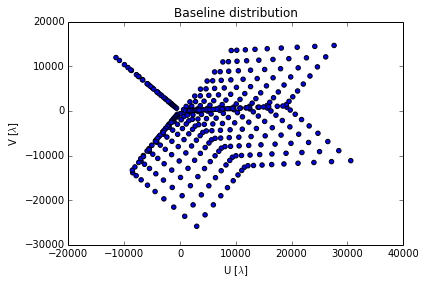

In [8]:
pl.subplot(111)
pl.scatter(basel_uvw[:,0],basel_uvw[:,1],c='b')
pl.title("Baseline distribution")
pl.xlabel(r"U [$\lambda$]")
pl.ylabel(r"V [$\lambda$]")
pl.show()

Note that we only have approximately half a plane of UVW points. Because the sky intensity will always be positive definite, we can infact mirror these samples using conjugate symmetry such that $$V(-{\mathbf u}) = V^{\ast}({\mathbf u}).$$ 

This means that our sampling actually looks like:

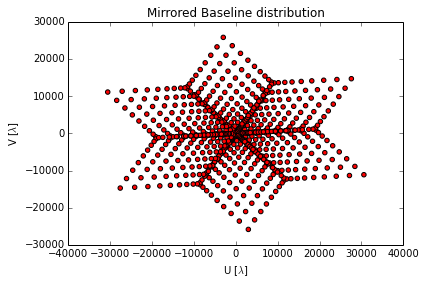

In [9]:
pl.subplot(111)
pl.scatter(basel_uvw[:,0],basel_uvw[:,1],c='r')
pl.scatter(-1.*basel_uvw[:,0],-1.*basel_uvw[:,1],c='r')
pl.title("Mirrored Baseline distribution")
pl.xlabel(r"U [$\lambda$]")
pl.ylabel(r"V [$\lambda$]")
pl.show()

At the moment our target field is empty, i.e. we have zero signal. We can put a point source into our target field by defining it at a position relative to the target field centre. We define this position in terms of direction cosines $${\mathbf x_0} = (l, m, n),$$ and give our source an amplitude of $$S_0.$$

In [10]:
l = 0.0005; m = 0.0005    # Units are Radians
src_pos=numpy.array([l, m , numpy.sqrt(1 - l**2 - m**2)])
src_amp = 100.0

The response of our interferometer to this source is given by 
$$V(\mathbf{u}) = \int{ S_0\, \delta({\mathbf x}-{\mathbf x_0})\,\exp(-2j\pi\, {\mathbf u}\cdot {\mathbf x})\, {\rm d}{\mathbf x}}$$

In [11]:
vis = src_amp*numpy.exp(-2j*numpy.pi* numpy.dot(basel_uvw[:,0:2], src_pos[0:2])) 

These are continuous complex visibilities. They are currently noiseless.

We can write out these data:

In [12]:
u = basel_uvw[:,0]
v = basel_uvw[:,1]
w = basel_uvw[:,2]
vis_re = vis.real
vis_im = vis.imag
numpy.savetxt('simulated_data.txt',numpy.column_stack((u,v,w,vis_re,vis_im)),newline='\n',fmt='%1.4e')

Done!